# Real-Time Predictions

Analysis of real-time predictions on four votes.

**Note:** For some reasons I can't explain, there are two requests that were not saved on `2020-02-09`:

- `2020-02-09-16-03`
- `2020-02-09-17-17`

I replicated the previous datapoints, i.e., at `16-01` and `17-15`, in order to avoid a hole in the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re

from collections import namedtuple
from glob import glob
from predictor import Predictor
from scraper import scrape_referendum

VERBOSE = False

ZHWT = set([
    230,  # Winterthur.
    261,  # Zurich.
])
KREISE = set([
    10230, 20230, 30230, 40230, 50230, 60230, 70230,  # Winterthur.
    10261, 20261, 61261, 40261, 50261, 60261, 70261, 80261, 90261  # Zurich.
])
DATES= ['2019-05-19', '2020-02-09']
VOTES = [
    6270,  # RFFA.
    6280,  # Schengen.
    6290,  # Affordable houses.
    6300,  # Discrimination.
]
VOTE2DATE = {
    6270: '2019-05-19',
    6280: '2019-05-19',
    6290: '2020-02-09',
    6300: '2020-02-09',
}
DATE2VOTES = {
    '2019-05-19': [6270, 6280],
    '2020-02-09': [6290, 6300]
}

Result = namedtuple('Result', 'vote ogd_id yes_percent num_valid')

## Load data

In [2]:
data = dict()
for date in DATES:
    files = glob(f'data/{date}/*.json')
    for i, file in enumerate(files):
        # Keep timestamp as YYYY-MM-DD-HH-mm.
        pattern = f'data-({date}-' + r'\d\d-\d\d)-\d\d.json'
        timestamp = re.sub(pattern, r'\1', os.path.basename(file))
        # Scrape JSON data.
        data[timestamp] = scrape_referendum(file)
        print(f'{date} {(i+1)/len(files)*100:.2f}%', end='\r')

In [3]:
%%time

# Get historical data.
munvotes, minfo, _ = Predictor.load_data('../data/munvoteinfo.pkl')
# Store predictions.
pred_data = dict()
for date in DATES:
    pred_data.update({v: list() for v in DATE2VOTES[date]})
    for vote in DATE2VOTES[date]:
        # Keep sorted list of timestamps.
        pattern = r'[\d]{4}-\d\d-\d\d-'
        sorted_ts = sorted(set([re.sub(pattern, r'', k) for k in data.keys()]))
        last = data['-'.join([date, sorted_ts[-1]])]
        N = 0
        for res in last:
            # Filter vote.
            if res['vote'] != vote:
                continue
            ogd = res['municipality']
            # If vote is 05-19, then ignore Kreise.
            if date == '2019-05-19':
                if ogd in KREISE:
                    continue
            # If vote is 09-02, ignore Zurich and Winterthur as municipalities.
            elif date == '2020-02-09':
                if ogd in ZHWT:
                    continue
            N += res['num_valid']

        # Define model.
        model = Predictor(munvotes, minfo, d=25, gamma=0.01, n_iter=20000)

        print(f'Generating predictions for vote {vote}...')
        preds = list()
        date = VOTE2DATE[vote]
        for i, ts in enumerate(sorted_ts):
            datum = data['-'.join([date, ts])]
            # Get observed and unobserved results.
            obs, uobs = list(), list()
            for res in datum:
                # Filter vote.
                if res['vote'] != vote:
                    continue
                ogd = res['municipality']
                # If vote is 05-19, then ignore Kreise.
                if date == '2019-05-19':
                    if ogd in KREISE:
                        continue
                # If vote is 09-02, ignore Zurich and Winterthur.
                elif date == '2020-02-09':
                    if ogd in ZHWT:
                        continue
                if res['yes_percent'] is not None:
                    obs.append(Result(
                        vote=res['vote'],
                        ogd_id=ogd,
                        yes_percent=res['yes_percent'],
                        num_valid=res['num_valid']
                    ))
                else:
                    if ogd in minfo.index:
                        uobs.append(Result(
                            vote=res['vote'],
                            ogd_id=ogd,
                            yes_percent=None,
                            num_valid=float(minfo.loc[ogd])
                        ))
            if len(obs) == 0:
                if VERBOSE:
                    print(f'Skipping {ts}: no result available.')
                continue

            # Predict national outcome.
            yp, _ = model.predict(obs)  # Get predictions in all municipalities.
            pred = model.aggregate(obs, uobs, yp)
            Nobs = np.sum([r.num_valid for r in obs])
            count = np.sum([r.yes_percent*r.num_valid for r in obs]) / Nobs
            preds.append({
                'timestamp': ts,
                'ypred': pred,
                'count': count,
                'counting': Nobs / N
            })
            pred = preds[-1]
            if VERBOSE:
                print(f'Prediction at {ts} for vote {vote}...')
                print(f'  Prediction:   {pred["ypred"]*100:.2f}%')
                print(f'  Counted:      {pred["count"]*100:.2f}%')
                print(f'  Observed:     {len(obs)}')
                print(f'  Unobserved:   {len(uobs)}')
                print(f'  Counting (p): {pred["counting"]*100:.2f}%')
            # Update progress.
            print(f'{(i+1)/len(sorted_ts)*100:.2f}%', end='\r')
            # Stop when we have counted all results.
            if Nobs == N:
                if VERBOSE:
                    print(f'Counting done ({ts}).')
                break
        pred_data[vote] = preds

Generating predictions for vote 6270...
Generating predictions for vote 6280...
Generating predictions for vote 6290...
Generating predictions for vote 6300...
CPU times: user 1min 29s, sys: 1.48 s, total: 1min 30s
Wall time: 55 s


### Save prediction data

In [4]:
with open(f'data/predictions.pkl', 'wb') as f:
    pickle.dump(pred_data, f)

## Load prediction

In [5]:
with open(f'data/predictions.pkl', 'rb') as f:
    pred_data = pickle.load(f)

## Plot prediction over time

Final count: 42.95%
First ypred: 41.80%
Difference:  1.15


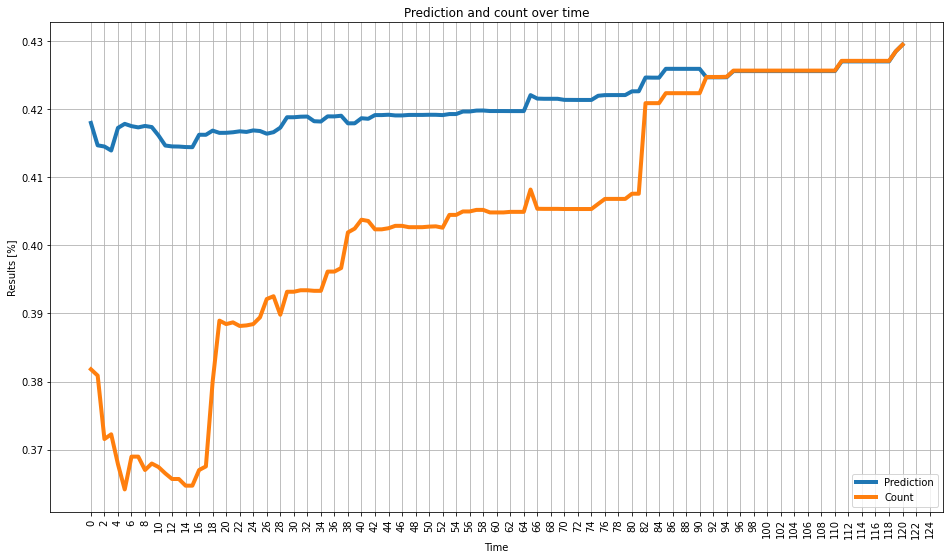

In [6]:
vote = 6290
preds = pred_data[vote]
ypred = [p['ypred'] for p in preds]
count = [p['count'] for p in preds]
x = np.arange(len(ypred))
# x = [p['counting'] for p in preds]

print(f'Final count: {count[-1]*100:.2f}%')
print(f'First ypred: {ypred[0]*100:.2f}%')
print(f'Difference:  {abs(count[-1]-ypred[0])*100:.2f}')
plt.figure(figsize=(16, 9))
plt.plot(x, ypred, linewidth=4, label='Prediction')
plt.plot(x, count, linewidth=4, label='Count')

plt.xticks(np.arange(0, 125, 2), rotation=90)
plt.title('Prediction and count over time')
# plt.xlim([0, 125])
plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Results [%]')
plt.grid()
plt.show()

I know, the predictions at `t=0` are slightly different from the paper.
I don't know how to explain this different, except that I updated the dependencies (and Python) when cleaning up this notebook for a public release.
I don't recall the exact versions I used when generating the predictions for the paper back in February 2020.
That being said, the new predictions are a bit better than the one reported in Table 3 of the paper.